In [22]:
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
%matplotlib inline

In [64]:
def find_cutoffs(nu,fnu,fnu_err,nu_nom,buff=5.,N_points=4): #buff = 5 GHz default
    '''
    FUNCTION TO TRUNCATE ACTPOL AND ADVACT BANDPASSES TO SENSIBLE REGIONS
    ---
    For PA1/2/3/4/5/6, determine upper and lower limits where to cut off bandpass
    integrals by finding where the responses
    become consistent with zero [or negative] (within the uncertainties) 
    after being positive for N_points above (below) this cutoff
    for the lower (upper) cutoff (default N_points = 4),
    and then going "buff" GHz beyond that. (default buff = 5 GHz)
    Also require lower cutoff < nu_nom and upper cutoff > nu_nom,
    where nu_nom is the "nominal" band center.
    ---
    Input:
    nu = array of frequencies at which bandpass is measured [GHz]
    fnu = bandpass measurements [dimensionless transmission]
    fnu_err = error bars on bandpass measurements
    nu_nom = bandpass nominal frequency
    buff = buffer to go past final determined cutoffs [GHz]
    N_points = number of consecutive positive measurements used
               to determine cutoffs
    Output:
    truncated arrays of nu, fnu, fnu_err
    '''
    N_nu = len(nu)
    assert(N_nu > 2*N_points)
    for i in range(N_nu-N_points):
        if (nu[i] < nu_nom and fnu[i]-fnu_err[i] <= 0. and all(x > 0. for x in fnu[i+1:i+N_points+1]-fnu_err[i+1:i+N_points+1])):
            lower_cutoff = nu[i]
            break
    for i in range(N_points,N_nu):
        if (nu[i] > nu_nom and fnu[i]-fnu_err[i] <= 0. and all(x > 0. for x in fnu[i-N_points:i]-fnu_err[i-N_points:i])):
            upper_cutoff = nu[i]
            break
    # include buffer on lower and upper cutoffs
    lower_cutoff -= buff
    upper_cutoff += buff
    # don't go beyond the edges of the measurements
    if (lower_cutoff < nu[0]):
        lower_cutoff = nu[0]
    if (upper_cutoff > nu[-1]):
        upper_cutoff = nu[-1]
    print("lower, upper = ",lower_cutoff, upper_cutoff)
    # instead of interpolating, just find elements in nu array nearest to the cutoffs
    idx_low = (np.abs(nu - lower_cutoff)).argmin()
    idx_high = (np.abs(nu - upper_cutoff)).argmin()
    # return the three truncated arrays
    return nu[idx_low:idx_high+1],fnu[idx_low:idx_high+1],fnu_err[idx_low:idx_high+1]

In [65]:
# read in ACTPol PA1/2/3 bandpass data
N_ACTPol = 4 #PA1, PA2, PA3_90, PA3_150
files_ACTPol = ['PA1_avg_passband_wErr.txt','PA2_avg_passband_wErr.txt','PA3_avg_passband_90_wErr.txt','PA3_avg_passband_150_wErr.txt']
nu_ACTPol = []
fnu_ACTPol = []
fnu_err_ACTPol = []

for i in range(N_ACTPol):
    nu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,0])
    fnu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,1])
    fnu_err_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,2])

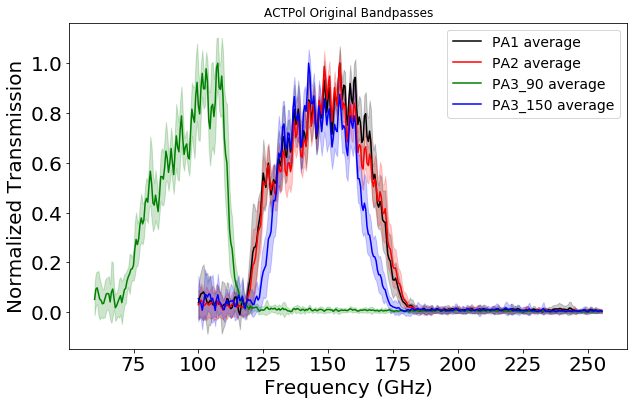

In [66]:
# plots of the original (untruncated) ACTPol bandpasses
# N.B.: from Rahul:
# PA1 = average of 18 individual detector FTSs
# PA2 = average of 75 individual detector FTSs
# PA3_90 = average of 17 individual detector FTSs
# PA3_150 = average of 28 individual detector FTSs

# plot all
colors = ['k','r','g','b']
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(N_ACTPol):
    plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.title("ACTPol Original Bandpasses")
plt.show()

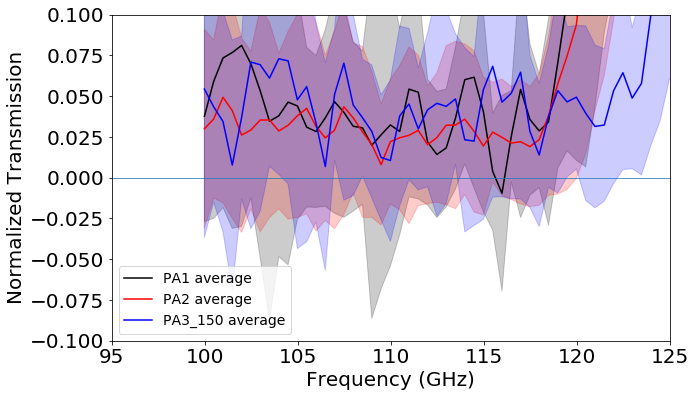

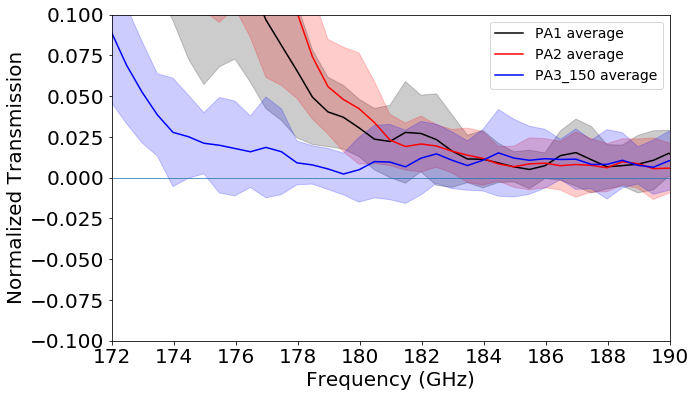

In [67]:
# zoom plots on 150 GHz cutoffs for ACTPol bandpasses
# 150 GHz zoom: upper cutoff
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    if (i != 2):
        plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(N_ACTPol):
    if (i != 2):
        plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_150 average'], fontsize=14)
plt.xlim(95.,125.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

# 150 GHz zoom: lower cutoff
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    if (i != 2):
        plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(N_ACTPol):
    if (i != 2):
        plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_150 average'], fontsize=14)
plt.xlim(172.,190.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

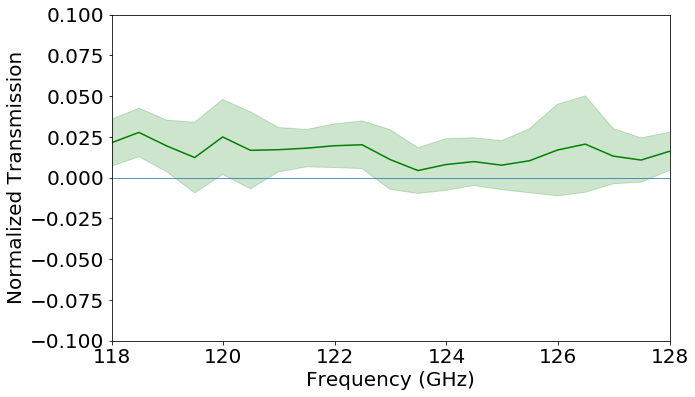

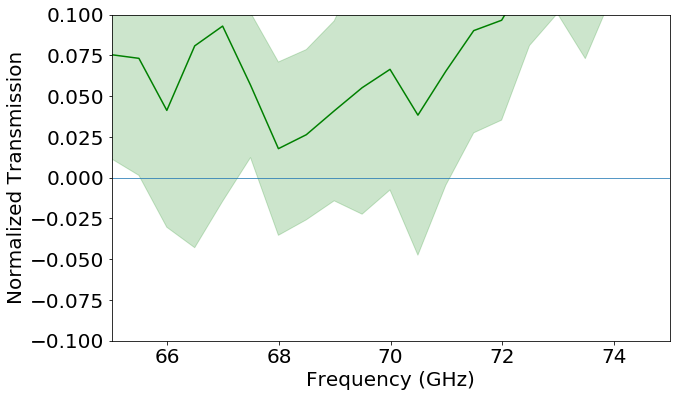

In [68]:
# zoom plots on 90 GHz cutoffs for ACTPol PA3_90 bandpass
# 90 GHz zoom: upper cutoff
plt.figure(figsize=(10,6))
plt.plot(nu_ACTPol[2], fnu_ACTPol[2], color=colors[2])
plt.fill_between(nu_ACTPol[2], fnu_ACTPol[2]-fnu_err_ACTPol[2], fnu_ACTPol[2]+fnu_err_ACTPol[2], color=colors[2], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(118.,128.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()
# 90 GHz zoom: lower cutoff
plt.figure(figsize=(10,6))
plt.plot(nu_ACTPol[2], fnu_ACTPol[2], color=colors[2])
plt.fill_between(nu_ACTPol[2], fnu_ACTPol[2]-fnu_err_ACTPol[2], fnu_ACTPol[2]+fnu_err_ACTPol[2], color=colors[2], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(65.,75.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()


In [69]:
# apply truncation function to ACTPol bandpasses

nu_ACTPol_cut = []
fnu_ACTPol_cut = []
fnu_err_ACTPol_cut = []

nu_nom = np.array([150.,150.,90.,150.])

for i in range(N_ACTPol):
    nu_cut, fnu_cut, fnu_err_cut = find_cutoffs(nu_ACTPol[i], fnu_ACTPol[i], fnu_err_ACTPol[i], nu_nom[i])
    nu_ACTPol_cut.append(nu_cut)
    fnu_ACTPol_cut.append(fnu_cut)
    fnu_err_ACTPol_cut.append(fnu_err_cut)

lower, upper =  113.49 186.48
lower, upper =  114.99 188.48
lower, upper =  65.99 124.49
lower, upper =  116.99 178.98


In [70]:
# save truncated versions
np.savetxt('PA1_avg_passband_wErr_trunc.txt', np.transpose(np.array([nu_ACTPol_cut[0], fnu_ACTPol_cut[0], fnu_err_ACTPol_cut[0]])))
np.savetxt('PA2_avg_passband_wErr_trunc.txt', np.transpose(np.array([nu_ACTPol_cut[1], fnu_ACTPol_cut[1], fnu_err_ACTPol_cut[1]])))
np.savetxt('PA3_avg_passband_90_wErr_trunc.txt', np.transpose(np.array([nu_ACTPol_cut[2], fnu_ACTPol_cut[2], fnu_err_ACTPol_cut[2]])))
np.savetxt('PA3_avg_passband_150_wErr_trunc.txt', np.transpose(np.array([nu_ACTPol_cut[3], fnu_ACTPol_cut[3], fnu_err_ACTPol_cut[3]])))


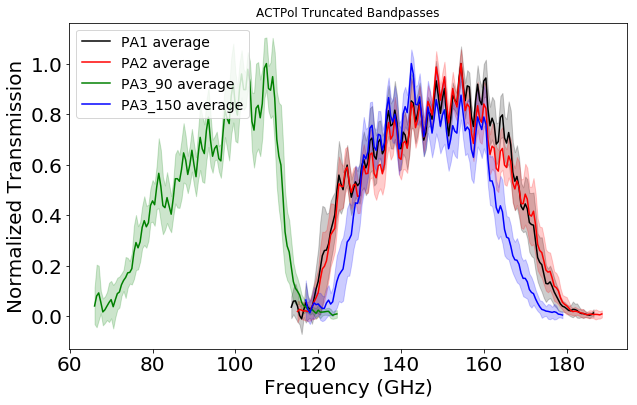

In [71]:
# plot truncated bandpasses
colors = ['k','r','g','b']
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.plot(nu_ACTPol_cut[i], fnu_ACTPol_cut[i], color=colors[i])
for i in range(N_ACTPol):
    plt.fill_between(nu_ACTPol_cut[i], fnu_ACTPol_cut[i]-fnu_err_ACTPol_cut[i], fnu_ACTPol_cut[i]+fnu_err_ACTPol_cut[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.title("ACTPol Truncated Bandpasses")
plt.show()